Install all necessary packages

In [2]:
!pip install ripser

     |████████████████████████████████| 81kB 2.7MB/s 
  Created wheel for ripser: filename=ripser-0.4.1-cp36-cp36m-linux_x86_64.whl size=423274 sha256=487a50e4dc67f7939419a24d626e07935289a97520f5c490dae17dcde34f26b0
  Stored in directory: /root/.cache/pip/wheels/d4/12/da/56d55c3af62ebd5e0684d521f3e58c1a85ac312502c9e2d47d
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18091 sha256=4daec454797dfdef8b0e8c432c0138ee258cfd85cb849ab34223c09cc8162585
  Stored in directory: /root/.cache/pip/wheels/2b/e1/c9/1993c7f7f114b7d3fb2d3e895e02157a7ebf554861e9e54e01
Successfully built ripser hopcroftkarp


Import packages and check gpu availability

In [0]:
# import PyTorch modules
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, WeightedRandomSampler, BatchSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
# make sure that we only run with GPU hardware acceleration
assert cuda.is_available()

# import relevant image processing modules and functions
from PIL import Image
import imageio
import cv2
from google.colab.patches import cv2_imshow

# import scientific computing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from ripser import ripser
from persim import plot_diagrams
import math

# import standard Python libraries
import random
import time
import os
import shutil
from shutil import copyfile
from collections import deque
from glob import glob
import pickle

Add Char74k data to environment, downloaded from http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

In [0]:
if os.path.exists("English"):
    shutil.rmtree("English")
!tar -xvzf EnglishHnd-2.tgz

Generate topological data from a file

In [0]:
def generate_point_cloud(filename, threshold = 0.005, plot = False):
    # threshold is the probability that white pixel is converted to a point
    image = cv2.imread(filename)
    x_points, y_points, points = [], [], []
    for i in range(900):
        for j in range(900):
            if image[i][j][0]==0:
                rand = np.random.random()
                if rand<threshold:
                    x_points.append(i)
                    y_points.append(j)
                    points.append(np.array([i, j]))
    if plot:
        plt.scatter(x_points, y_points, marker = '+')
        plt.show()
    
    return np.array(points).reshape(len(points), 2)

def generate_data_from_file(file_name, dimension):
    point_cloud = generate_point_cloud(file_name, plot = False)
    diagrams = ripser(point_cloud)['dgms']
    H0_points, H1_points = diagrams
    diff = lambda x: x[1]-x[0]
    H1_diffs = torch.Tensor([diff(point) for point in H1_points])  
    adj_dimension = min(dimension, len(H1_diffs))
    top_H1_diffs, indices = H1_diffs.topk(adj_dimension)
    
    return top_H1_diffs

Save or load `.pkl` files.

In [0]:
# Load topology data from .pkl as list
with open('topology_data.pkl', 'rb') as file:
    topology_data = pickle.load(file)
    
# pad the vector with 0's
processed_top_data = []
for index, top_vector in topology_data:
    padded = np.zeros(20, dtype=np.float32)
    padded[:len(top_vector)] = top_vector
    processed_top_data.append(padded)

In [0]:
# Load char74k_preprocess
with open('chars74k_preprocess.pkl', 'rb') as file:
    char74k_preprocess = pickle.load(file)

In [8]:
# inspect contents of list
char74k_preprocess[:5]

[('English/Hnd/Img/Sample001/img001-001.png',
  tensor([211.0447,  14.3713,  13.1418,  12.1520,  12.0411,  11.8406,  11.7333,
           11.6335,  10.8927,  10.0658,  10.0602,   9.1535,   8.7868,   8.6259,
            8.5266,   8.1570,   8.0923,   7.5575,   7.3282,   7.2225]),
  0),
 ('English/Hnd/Img/Sample001/img001-002.png',
  tensor([164.9863,  15.1877,  15.0261,  13.5837,  12.5237,  12.3367,  11.1662,
           11.1090,  10.9210,  10.0602,   9.7182,   9.5444,   8.5666,   8.1550,
            8.1511,   7.9268,   7.3270,   6.9286,   6.6593,   6.6290]),
  0),
 ('English/Hnd/Img/Sample001/img001-003.png',
  tensor([371.8539,  14.7236,  13.2472,  13.0420,  12.4390,  11.7919,  11.6645,
           10.9211,  10.2955,   9.9863,   9.7676,   7.7877,   7.5544,   7.1938,
            7.1372,   7.0380,   6.9806,   6.5493,   6.1153,   5.9960]),
  0),
 ('English/Hnd/Img/Sample001/img001-004.png',
  tensor([108.1573,  15.1873,  12.0097,   9.1970,   8.4066,   8.3818,   8.3475,
            6.6572,   

Define the data sets that we will use in our experiments.
*    Character Dataset
 *   Images + labels
 *   Topological features + images + labels

In [0]:
MAX_HOLES = 10

class ImageData(Dataset):
    def __init__(self, image_file_locations, labels):
        self.image_file_locations = image_file_locations
        self.images = [Image.open(file) for file in image_file_locations]
        self.images = [image.resize((200, 200)) for image in self.images]
        self.image_np_arrays = [np.array(image, dtype=np.float32).transpose((2,0,1)) for image in self.images]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.image_np_arrays[idx], self.labels[idx]

class TopologicalData(Dataset):
    def __init__(self, topology_data, labels):
        self.topology_data = topology_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.topology_data[idx], self.labels[idx]

class ImageAndTopologicalData(Dataset):
    def __init__(self, image_file_locations, topology_data, labels):
        self.image_file_locations = image_file_locations
        self.images = [Image.open(file) for file in image_file_locations]
        self.images = [image.resize((200, 200)) for image in self.images]
        self.image_np_arrays = [np.array(image, dtype=np.float32).transpose((2,0,1)) for image in self.images]
        self.topology_data = topology_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.image_np_arrays[idx], self.topology_data[idx]), self.labels[idx]

In [0]:
# Character Datasets
char_files, char_top_data_raw, char_labels = zip(*char74k_preprocess)
padded_top_data = []
for top_vector in char_top_data_raw:
    padded = np.zeros(20, dtype=np.float32)
    padded[:len(top_vector)] = top_vector
    padded_top_data.append(padded)

char_image_data = ImageData(char_files, char_labels)
char_image_and_topological_data = ImageAndTopologicalData(char_files, padded_top_data, char_labels)

In [0]:
indices = list(range(len(char_labels)))
np.random.shuffle(indices)
file_label_pairs = np.array(list(zip(char_files, char_labels)))
train, valid, test = file_label_pairs[: 341*7], file_label_pairs[341*7: 341*8], file_label_pairs[341*8:]
with open('file_label_test_pairs.pkl', 'wb') as file:
    pickle.dump(test, file)

Define the functions that we will use to initialize the DataLoader's that we will use for our experiments. Make sure that the data sets have been initialized in the previous cell.

In [0]:
bs = 64 # may need to be adjusted depending on GPU size

def get_stratified_sampler(data):
    labels = [label for _, label in data]
    frequencies = np.bincount(labels)
    weights = [1/frequencies[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

def get_data_loaders(data, split=(7000, 1000, 2000)):
    train, validation, test = torch.utils.data.random_split(data, split)
    train_loader = DataLoader(train, sampler=get_stratified_sampler(train), batch_size=bs)
    validation_loader = DataLoader(validation, sampler=get_stratified_sampler(validation), batch_size=bs)
    test_loader = DataLoader(test, sampler=get_stratified_sampler(test), batch_size=bs)
    return train_loader, validation_loader, test_loader


Define the Neural Network structures that we will use for our experiments.
These include

*   Vanilla Convolutional Neural Network
*   Convolutional Neural Network with OrdinalRegression Layer with pre-determined thresholds
*   Convolutional Neural Network with OrdinalRegression Layer with trainable thresholds
*   Sparse single-layer network with sigmoid activation (for inputting homological data)



In [0]:
# baseline model, one-layer convnet
class ConvNet(torch.nn.Module):

    # batch shape for input x is (bs, img_size, img_size)
    
    def __init__(self, conv_dropout=0.0, fc_dropout=0.0, num_labels=11):
        super(ConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=num_labels, conv_dropout=conv_dropout, fc_dropout=fc_dropout)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, inference=False):
        x = self.conv_block(x)

        # We handle training and inference separately, see documentation for CrossEntropyLoss
        # https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        if inference:
            x = self.softmax(x)
            return x
        else:
            return x

class ConvBlock(nn.Module):
    def __init__(self, conv_dropout=0.2, fc_dropout=0.2, output_size=10):
        super(ConvBlock, self).__init__()
                
        self.conv = nn.Conv2d(3, 1, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(1, 3, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv_dropout = nn.Dropout2d(p=conv_dropout)
        self.conv3 = nn.Conv2d(3, 3, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(3, 3, kernel_size=3, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(300, 100)
        self.dropout = nn.Dropout(p=fc_dropout)
        self.fc2 = nn.Linear(100, 80)
        self.dropout2 = nn.Dropout(p=fc_dropout)
        self.fc3 = nn.Linear(80, 60)
        self.fc4 = nn.Linear(60, output_size)

    def forward(self, x, inference=False):
        
        # Computes activation of the first convolution
        # Size changes from (bs, img_size, img_size) to (cnn_output, img_size, img_size)
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv_dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
class OrdinalRegressionLayer(nn.Module):
    """
    Expected input shape: (batch_size, 1)
    Expected output shape: (batch_size, num_labels)

    Assume that we are running on cuda
    """
    def __init__(self, num_labels=10, trainable=False):
        self.num_labels = num_labels
        super(OrdinalRegressionLayer, self).__init__()
        self.register_buffer("partition", torch.zeros(num_labels + 1))
        cutoffs = nn.Parameter(torch.Tensor(np.linspace(start=0, stop=10, num=self.num_labels - 1)))
        self.register_parameter("cutoffs", cutoffs)
        self.cutoffs.requires_grad = trainable
        self.partition[1: -1] = self.cutoffs
        self.partition[0] = -float("inf")
        self.partition[-1] = float("inf")
        self.register_buffer("left_tensor", self.partition[:-1])
        self.register_buffer("right_tensor", self.partition[1:])

        
    def forward(self, x):
        # array broadcasting handles adding tensors of shape (batch_size, num_labels) and (batch_size, 1)
        prob1 = torch.sigmoid(self.right_tensor - x)
        prob2 = torch.sigmoid(self.left_tensor - x)
        return prob1 - prob2
    
    def extra_repr(self):
        return 'outputs={}'.format(self.num_labels)

# baseline model, one-layer convnet
class OrdinalConvNet(nn.Module):
    # batch shape for input x is (bs, img_size, img_size)
    def __init__(self, conv_dropout=0.0, fc_dropout=0.0, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=num_labels)
        self.fc = nn.Linear(num_labels, 1)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels, trainable=trainable_ordinal_thresholds)
        
    def forward(self, x, inference=False):
        
        # Computes activation of the first convolution
        # Size changes from (bs, img_size, img_size) to (cnn_output, img_size, img_size)
        x = self.conv_block(x)
        x = self.fc(x)
        x = self.ordinal_regression(x)
        # We handle training and inference separately because NLLLoss expects log-probabilities, see documentation
        # https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss
        if inference:
            return x
        else:
            x = torch.log(x)
            return x

In [0]:
class SparseLinear(nn.Module):
    def __init__(self, input_size, single_scaling=True):
        self.input_size = input_size
        super(SparseLinear, self).__init__()
        weights = nn.Parameter(torch.Tensor(1 if single_scaling else self.input_size).float())
        self.register_parameter("weights", weights)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(1).float()))
        nn.init.normal_(self.weights.data, 1, 1/self.input_size)
        nn.init.normal_(self.bias.data, 0, 1)
    def forward(self, x):
        return x * self.weights + self.bias
    
    def extra_repr(self):
        return 'features={}'.format(self.input_size)
        

class OrdinalTopNet(torch.nn.Module):
    def __init__(self, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalTopNet, self).__init__()
        self.sparse_linear = SparseLinear(input_size=20)
        self.fc = nn.Linear(20, 1)
        nn.init.normal_(self.fc.weight.data, mean=0.5, std=1/20)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels, trainable=trainable_ordinal_thresholds)

    def forward(self, x, inference=False):
        # Use broadcasting to multiply Tensors of size (batch_size, 20) and (20,)
        x = torch.sigmoid(self.sparse_linear(x))
        x = self.fc(x)
        x = self.ordinal_regression(x)
        # We handle training and inference separately because NLLLoss expects log-probabilities, see documentation
        # https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss
        if inference:
            return x
        else:
            x = torch.log(x)
            return x
    def extr_reptr(self):
        return 'num_labels={}'.format(num_labels)

OrdinalTopNet()

OrdinalTopNet(
  (sparse_linear): SparseLinear(features=20)
  (fc): Linear(in_features=20, out_features=1, bias=True)
  (ordinal_regression): OrdinalRegressionLayer(outputs=10)
)

In [0]:
class TopConvNet(nn.Module):
    # batch shape for input x is (bs, img_size, img_size)
    def __init__(self, conv_output_size=1, output_size=10, add_softmax=False, conv_dropout=0.2, fc_dropout=0.2, include_fcc2=False):
        super(TopConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=conv_output_size, conv_dropout=conv_dropout, fc_dropout=fc_dropout)
        self.sparse_linear = SparseLinear(20)
        self.fcc = nn.Linear(conv_output_size + 20, output_size)
        self.include_fcc2 = include_fcc2
        if self.include_fcc2:
            self.fcc2 = nn.Linear(output_size, output_size)
        self.add_softmax = add_softmax
        if self.add_softmax:
            self.softmax = nn.Softmax(dim=1)
       
    def forward(self, inputs):
        x, y = inputs
        x = self.conv_block(x)
        y = torch.sigmoid(self.sparse_linear(y))

        z = torch.cat([x, y], dim=1)
        z = self.fcc(z)
        if self.include_fcc2:
            z = self.fcc2(z)
        if self.add_softmax:
            z = self.softmax(z)
        return z

class OrdinalTopConvNet(nn.Module):
    def __init__(self, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalTopConvNet, self).__init__()
        self.top_conv_net = TopConvNet(conv_output_size=num_labels, output_size=num_labels)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels)
    def forward(self, inputs, inference=False):
        z = self.top_conv_net(inputs)
        z = self.ordinal_regression(z)
        if inference:
            return z
        else:
            z = torch.log(z)
            return z
OrdinalTopConvNet()

OrdinalTopConvNet(
  (top_conv_net): TopConvNet(
    (conv_block): ConvBlock(
      (conv): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_dropout): Dropout2d(p=0.2, inplace=False)
      (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
      (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv4): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
      (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=300, out_features=100, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=100, out_features=80, bias=True)
      (dropout2): Dropout(p=0.2, inplace=False)
      (fc3): Linear(in_features=

Define the training and evaluation functions. Also define the plots.

In [0]:
def train(model, optimizer, criterion, num_epochs, train_loader, validation_loader, save_model, cuda=True, report_every=10):
    start = time.time()
    if cuda:
        model = model.cuda()
    losses = {'validation': [], 'train': []}
    best_validation_loss = float("inf")
    data_loaders = {'validation': validation_loader, 'train': train_loader}
    try:
        for epoch in range(num_epochs):
            for phase in ['validation', 'train']:
                if phase == 'train':
                    model.train(True)
                else:
                    model.train(False)
                epoch_loss = 0
                batch_counter = 0
                for inputs, labels in data_loaders[phase]:
                    if cuda:
                        labels = labels.cuda()
                        if type(inputs) == list:
                            inputs = [inpt.cuda() for inpt in inputs]
                        else:
                            inputs = inputs.cuda()
                    output = model(inputs)
                    loss = criterion(output, labels)
                    optimizer.zero_grad()
                    if phase == 'train':
                        loss.backward(retain_graph=True)
                        optimizer.step()
                    # calculate epoch loss through running total
                    epoch_loss += loss.item()
                    batch_counter += 1
                losses[phase].append(epoch_loss / batch_counter)
                if phase == 'validation':
                    if losses[phase][-1] < best_validation_loss:
                        best_validation_loss = losses[phase][-1]
                        torch.save(model.state_dict(), save_model)
                if (epoch + 1)% report_every == 0:
                    print("Epoch: " + str(epoch + 1) + "," + " {} loss: ".format(phase) + str(losses[phase][-1]))
                    if phase == "train":
                        print("Time elapsed: {} seconds".format('%.3f'%(time.time() - start)))
    except KeyboardInterrupt:
        print("You have stopped the training early.")
    print("Best validation loss: {}".format(best_validation_loss))
    return losses


def evaluate(model, best_model_file, test_loader, criterion):
    model.eval()
    model.cuda()
    for model_version in ['final', 'best']:
        test_labels = []
        test_preds = []
        test_loss = 0
        if model_version == 'best':
            model.load_state_dict(torch.load(best_model_file))
        with torch.no_grad():
            test_points_counter = 0
            for inputs, labels in test_loader:
                test_labels += list(labels)
                if type(inputs) == list:
                    inputs = [inpt.cuda() for inpt in inputs]
                else:
                    inputs = inputs.cuda()
                labels = torch.LongTensor([int(label) for label in labels]).cuda()
                output = model(inputs)
                loss = criterion(output, labels)
                test_loss += loss.item() # divide by normalizing constant
                preds = output.argmax(dim=1) # check this, want to find largest probability from softmax layer
                test_preds += list(preds)
                test_points_counter += 1
        accuracy = sum(np.asarray(test_labels) == np.asarray(test_preds)) / len(test_labels)
        print("Test Loss: {} on {} model".format(str(test_loss / test_points_counter), model_version))
        print("Accuracy: {} on {} model".format(str(accuracy), model_version))


def plot(losses, title, length=25):
    plt.figure(title)
    plt.plot([i for i in range(1, length + 1)], losses["train"][:length], label="Training Loss")
    plt.plot([i for i in range(1, length + 1)], losses["validation"][:length], label="Validation Loss")
    plt.ylabel("Negative Log-Likelihood")
    plt.xlabel("Epochs")
    plt.title(title)
    plt.legend()
    plt.show()



Initialize DataLoader's

In [0]:
# Toy Dataset
split = [7000, 1000, 2000]
image_train, image_validation, image_test = get_data_loaders(image_data, split=split)
top_train, top_validation, top_test = get_data_loaders(topological_data, split=split)
image_top_train, image_top_validation, image_and_top_test = get_data_loaders(image_and_topological_data, split=split)

In [0]:
# Character Dataset
split = [341 * 7, 341, 341 * 2]
char_image_train, char_image_validation, char_image_test = get_data_loaders(char_image_data, split=split)
char_image_top_train, char_image_top_validation, char_image_top_test = get_data_loaders(char_image_and_topological_data, split=split)

Train the following models with the appropriate loss function

In [0]:
# Character Dataset Experiments

criterion = nn.CrossEntropyLoss()
char_conv_model = ConvNet(num_labels=62)
optimizer = optim.Adam(char_conv_model.parameters(), lr=0.0001, weight_decay=0.001)
char_conv_losses = train(char_conv_model, optimizer=optimizer, criterion=criterion, save_model="ConvNet_char.pkl", num_epochs=50, 
      train_loader=char_image_train, validation_loader=char_image_validation, cuda=True, report_every=5)

criterion = nn.CrossEntropyLoss()
char_top_conv_model = TopConvNet(conv_output_size=62, output_size=62, include_fcc2=True)
optimizer = optim.Adam(char_top_conv_model.parameters(), lr=0.0001, weight_decay=0.001)
char_top_conv_losses = train(char_top_conv_model, optimizer=optimizer, criterion=criterion, save_model="TopConvNet_char.pkl", num_epochs=100, 
      train_loader=char_image_top_train, validation_loader=char_image_top_validation, cuda=True, report_every=5)

Epoch: 5, validation loss: 3.997307618459066
Epoch: 5, train loss: 3.9053435200139095
Time elapsed: 6.526 seconds
Epoch: 10, validation loss: 3.2072654565175376
Epoch: 10, train loss: 2.804025643750241
Time elapsed: 13.029 seconds
Epoch: 15, validation loss: 2.9358203013738
Epoch: 15, train loss: 2.2066584198098433
Time elapsed: 19.462 seconds
Epoch: 20, validation loss: 2.598851720492045
Epoch: 20, train loss: 1.8961854577064514
Time elapsed: 25.903 seconds
Epoch: 25, validation loss: 2.68564240137736
Epoch: 25, train loss: 1.6338336593226384
Time elapsed: 32.345 seconds
Epoch: 30, validation loss: 2.433336098988851
Epoch: 30, train loss: 1.450849740128768
Time elapsed: 38.777 seconds
Epoch: 35, validation loss: 2.4441680908203125
Epoch: 35, train loss: 1.2409601540941941
Time elapsed: 45.222 seconds
Epoch: 40, validation loss: 2.879784186681112
Epoch: 40, train loss: 1.1164559816059314
Time elapsed: 51.635 seconds
Epoch: 45, validation loss: 2.645486275355021
Epoch: 45, train loss: 1

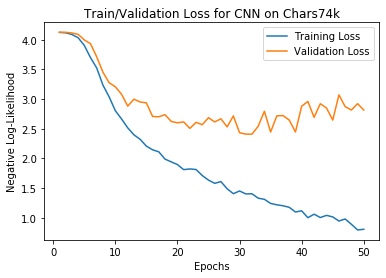

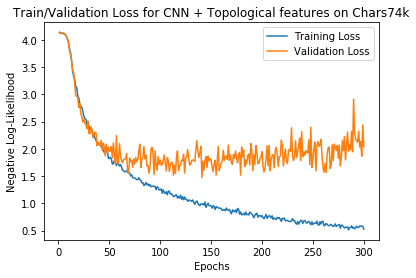

In [0]:
plot(char_conv_losses, "Train/Validation Loss for CNN on Chars74k", length=50)
plot(char_top_conv_losses, "Train/Validation Loss for CNN + Topological features on Chars74k", length=300)

In [0]:
print("Vanilla")
evaluate(char_conv_model, "ConvNet_char.pkl", char_image_test, nn.CrossEntropyLoss())
print("TopConvNet")
evaluate(char_top_conv_model, "TopConvNet_char.pkl", char_image_top_test, nn.CrossEntropyLoss())

Vanilla
Test Loss: 2.6641799319874155 on final model
Accuracy: 0.38269794721407624 on final model
Test Loss: 2.7329801429401743 on best model
Accuracy: 0.3914956011730205 on best model
TopConvNet
Test Loss: 1.8030292337590998 on final model
Accuracy: 0.5542521994134897 on final model
Test Loss: 1.662741249257868 on best model
Accuracy: 0.5762463343108505 on best model


In [0]:
# Shuffle the topological features and test
test_indices = char_image_top_test.dataset.indices
file_locs = char_image_and_topological_data.image_file_locations
top_data = char_image_and_topological_data.topology_data
labels = char_image_and_topological_data.labels
test_file_locs = [file_locs[i] for i in test_indices]
test_top_data = [np.random.normal(100000, 1000, size=20).astype(np.float32) for i in test_indices]
test_labels = [labels[i] for i in test_indices]
np.random.shuffle(test_top_data)

shuffled_dataset = ImageAndTopologicalData(test_file_locs, test_top_data, test_labels)
shuffled_dataloader = DataLoader(shuffled_dataset, sampler=get_stratified_sampler(shuffled_dataset), batch_size=bs)
evaluate(char_top_conv_model, "TopConvNet_char.pkl", shuffled_dataloader, nn.CrossEntropyLoss())

Test Loss: 1.5741951357234607 on final model
Accuracy: 0.6070381231671554 on final model
Test Loss: 1.732188799164512 on best model
Accuracy: 0.5615835777126099 on best model
